In [1]:
import os
import ast
import sys
import time
import yaml

from pymongo import MongoClient
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sbs
sbs.set()


import pandas as pd
import numpy as np
from dotenv import load_dotenv
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Normally where to do this? (in which function?)
with open("../gradio_config.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)

# Initialise mongo client.
mongo_client = MongoClient(config["database"]["uri"])

In [27]:
def load_mongodb():
    # Connect to the MongoDB client
    try:
        db = mongo_client[config["database"]["name"]]
        train_documents = db[config["database"]["train_collection"]].find()
        print("Train data successfully fetched from MongoDB\n")
    except Exception as error: 
        print(f"Unable to fetch train data from MongoDB. Check your connection the database...\nERROR: {error}\n")
        sys.exit()   
    try:
        test_docs = db[config["database"]["test_collection"]].find()
        print("Test data successfully fetched from MongoDB\n")
    except:
        print(f"Unable to fetch test data from MongoDB. Check your connection the database...\nERROR: {error}\n")
        sys.exit()
    df_train = pd.DataFrame.from_dict(list(train_documents))
    df_test = pd.DataFrame.from_dict(list(test_docs))
    df = pd.concat([df_train, df_test], axis=0)
    return df

df= load_mongodb()

Train data successfully fetched from MongoDB

Test data successfully fetched from MongoDB



In [3]:
def scale_body_embeddings(df):
    print("Processing embedding data and scaling data...\n")
    #Deserializing the embeddings
    body_embeddings = np.array(df['embeddings'].apply(ast.literal_eval).tolist())
    
    # Standardize embeddings
    scaler = StandardScaler()
    embeddings = scaler.fit_transform(body_embeddings)
    return embeddings

def scale_title_embeddings(df):
    print("Processing embedding data and scaling data...\n")
    #Deserializing the embeddings
    title_embeddings = np.array(df['Title_embeddings'].apply(ast.literal_eval).tolist())
    
    # Standardize embeddings
    scaler = StandardScaler()
    embeddings = scaler.fit_transform(title_embeddings)
    return embeddings

def scale_body_text_embeddings(df):
    title_embeddings = np.array(df['Title_embeddings'].apply(ast.literal_eval).tolist())
    body_embeddings = np.array(df['embeddings'].apply(ast.literal_eval).tolist())

    title_weight = 0.7
    body_weight = 0.3
    combined_embeddings = title_weight * title_embeddings + body_weight * body_embeddings
    
    # Standardize embeddings
    scaler = StandardScaler()
    embeddings = scaler.fit_transform(combined_embeddings)
    return embeddings

def get_variance_performance_with_pca(train_embeddings):
# Experiment for this variance range of 92% to 95%
    print("Finding best Model parameters...\n")
    variance = 0.95

    pca = PCA(n_components=variance)
    print(f"Dimensions before PCA: {train_embeddings.shape}\n")
    train_pca_embeddings = pca.fit_transform(train_embeddings)
    print(f"Dimensions after PCA: {train_pca_embeddings.shape}\n")
        
    # Range of max_d values to try, for this dataset we use 65
    max_d = 0.6
        
    # List to store silhouette scores
    silhouette_scores_train = []

    # Perform hierarchical clustering
    Z = linkage(train_pca_embeddings, method='average', metric='cosine')

    clusters_train = fcluster(Z, max_d, criterion='distance')
            
    # Calculate silhouette score only if there are at least 2 unique clusters and fewer than the number of samples
    if 1 < len(set(clusters_train)) < len(train_pca_embeddings):
        score_train = silhouette_score(train_pca_embeddings, clusters_train)
    else:
        score_train = -1  # Assign a score of -1 if less than 2 unique clusters or too many clusters
            
    silhouette_scores_train.append(score_train)

    # Plot the dendrogram
    plt.figure(figsize=(200, 15))
    plt.title(f'Dendrogram for Variance: {variance} (Body Embeddings with PCA)')
    dendrogram(Z)
    plt.axhline(y=max_d, color='r', linestyle='--')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.savefig(f'../clustering/dendrogram_variance_{variance}.png')
    
def get_variance_performance_without_pca(train_embeddings):
    # Experiment for this variance range of 92% to 95%
    print("Finding best Model parameters...\n")
    variance = 0.95

    print(f"Dimensions before PCA: {train_embeddings.shape}\n")
        
    # Range of max_d values to try, for this dataset we use 65
    max_d = 0.6
        
    # List to store silhouette scores
    silhouette_scores_train = []

    # Perform hierarchical clustering
    Z = linkage(train_embeddings, method='average', metric='cosine')

    clusters_train = fcluster(Z, max_d, criterion='distance')
            
    # Calculate silhouette score only if there are at least 2 unique clusters and fewer than the number of samples
    if 1 < len(set(clusters_train)) < len(train_embeddings):
        score_train = silhouette_score(train_embeddings, clusters_train)
    else:
        score_train = -1  # Assign a score of -1 if less than 2 unique clusters or too many clusters
            
    silhouette_scores_train.append(score_train)

    # Plot the dendrogram
    plt.figure(figsize=(200, 15))
    plt.title(f'Dendrogram for Variance: {variance} (Body Embeddings with PCA)')
    dendrogram(Z)
    plt.axhline(y=max_d, color='r', linestyle='--')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.savefig(f'../clustering/dendrogram_variance_{variance}.png')


## Exploring the Text embeddings

Processing embedding data and scaling data...

Finding best Model parameters...

Dimensions before PCA: (2007, 768)

Dimensions after PCA: (2007, 263)

Total time taken with PCA: 9.53 seconds. No hyperparameter tuning was done here.


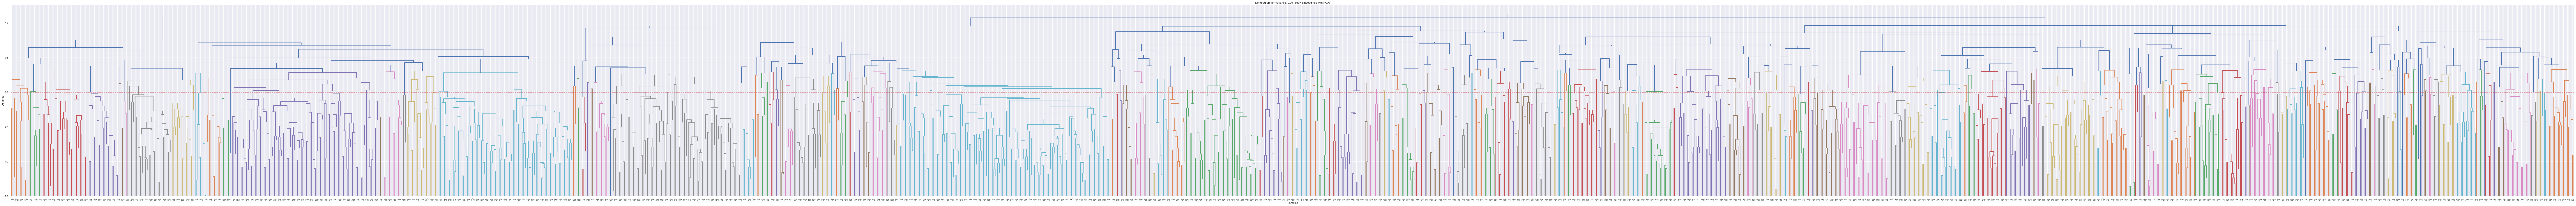

In [4]:
start_time = time.time()
# Your main code block
train_embeddings = scale_body_embeddings(df)
variance_perf = get_variance_performance_with_pca(train_embeddings)
# End the timer
end_time = time.time()
# Calculate the total time taken
total_time_with_pca = end_time - start_time
print(f"Total time taken with PCA: {round(total_time_with_pca,2)} seconds. No hyperparameter tuning was done here.")

Processing embedding data and scaling data...

Finding best Model parameters...

Dimensions before PCA: (2007, 768)

Total time taken without PCA: 10.3 seconds. No hyperparameter tuning was done here.


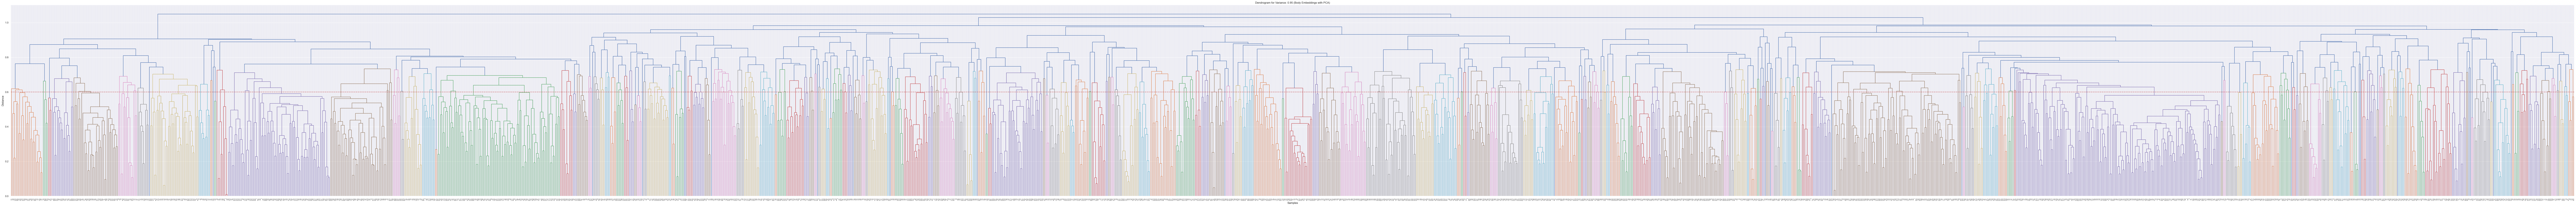

In [5]:
start_time = time.time()
# Your main code block
train_embeddings = scale_body_embeddings(df)
variance_perf = get_variance_performance_without_pca(train_embeddings)
# End the timer
end_time = time.time()
# Calculate the total time taken
total_time_with_pca = end_time - start_time
print(f"Total time taken without PCA: {round(total_time_with_pca,2)} seconds. No hyperparameter tuning was done here.")

## Exploring the Title Embeddings

Processing embedding data and scaling data...

Finding best Model parameters...

Dimensions before PCA: (2007, 768)

Dimensions after PCA: (2007, 326)

Total time taken with PCA: 9.54 seconds. No hyperparameter tuning was done here.


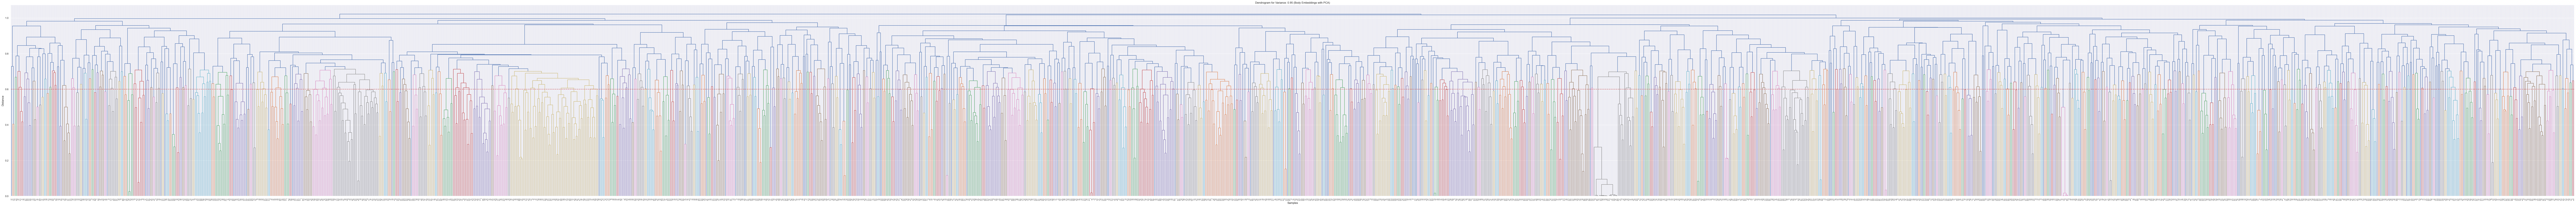

In [6]:
start_time = time.time()
# Your main code block
train_embeddings = scale_title_embeddings(df)
variance_perf = get_variance_performance_with_pca(train_embeddings)
# End the timer
end_time = time.time()
# Calculate the total time taken
total_time_with_pca = end_time - start_time
print(f"Total time taken with PCA: {round(total_time_with_pca,2)} seconds. No hyperparameter tuning was done here.")

Processing embedding data and scaling data...

Finding best Model parameters...

Dimensions before PCA: (2007, 768)

Total time taken without PCA: 10.99 seconds. No hyperparameter tuning was done here.


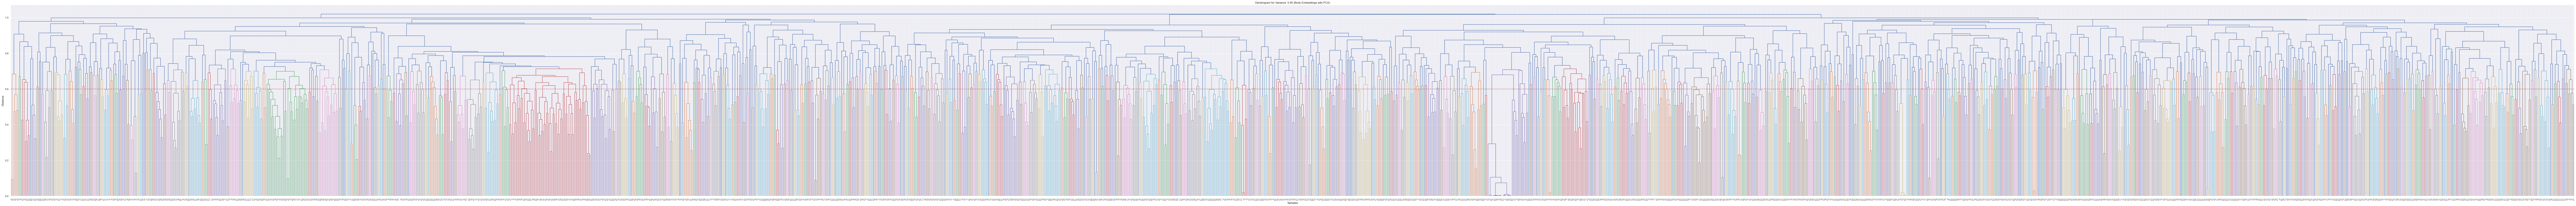

In [7]:
start_time = time.time()
# Your main code block
train_embeddings = scale_title_embeddings(df)
variance_perf = get_variance_performance_without_pca(train_embeddings)
# End the timer
end_time = time.time()
# Calculate the total time taken
total_time_with_pca = end_time - start_time
print(f"Total time taken without PCA: {round(total_time_with_pca,2)} seconds. No hyperparameter tuning was done here.")

## Exploring the concatenation of Text and Title embeddings

Finding best Model parameters...

Dimensions before PCA: (2007, 768)

Dimensions after PCA: (2007, 300)

Total time taken with PCA: 12.09 seconds. No hyperparameter tuning was done here.


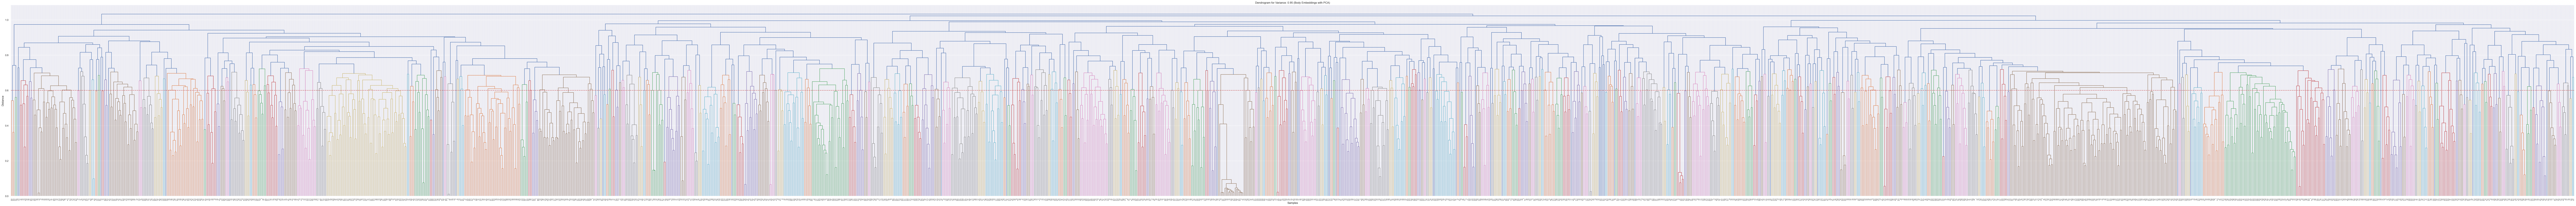

In [8]:
start_time = time.time()
# Your main code block
train_embeddings = scale_body_text_embeddings(df)
variance_perf = get_variance_performance_with_pca(train_embeddings)
# End the timer
end_time = time.time()
# Calculate the total time taken
total_time_with_pca = end_time - start_time
print(f"Total time taken with PCA: {round(total_time_with_pca,2)} seconds. No hyperparameter tuning was done here.")

Finding best Model parameters...

Dimensions before PCA: (2007, 768)

Total time taken without PCA: 13.0 seconds. No hyperparameter tuning was done here.


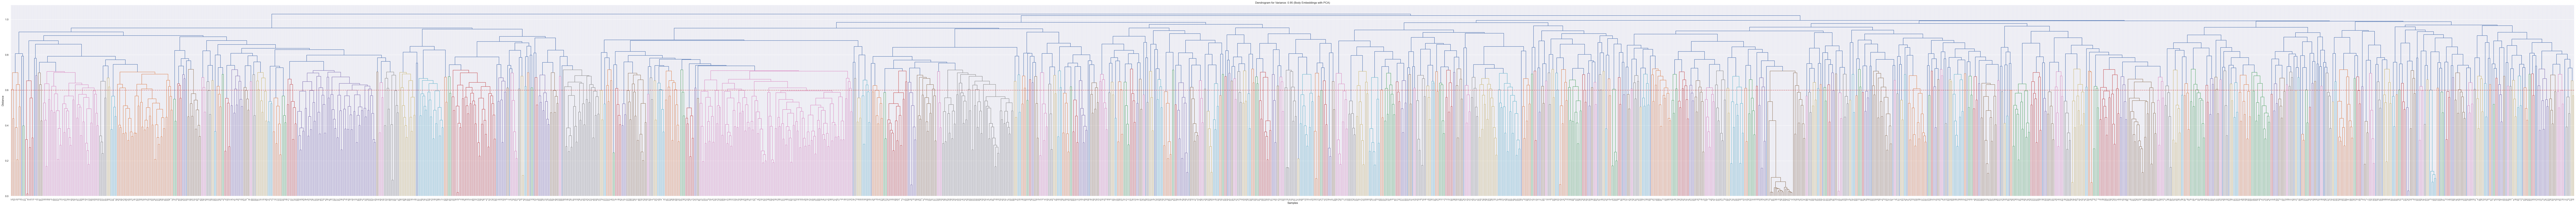

In [9]:
start_time = time.time()
# Your main code block
train_embeddings = scale_body_text_embeddings(df)
variance_perf = get_variance_performance_without_pca(train_embeddings)
# End the timer
end_time = time.time()
# Calculate the total time taken
total_time_with_pca = end_time - start_time
print(f"Total time taken without PCA: {round(total_time_with_pca,2)} seconds. No hyperparameter tuning was done here.")

## Exploring the different max_d heights

In [25]:
# Change type of embeddings accordingly
train_embeddings = scale_body_embeddings(df)

# Pre computed hierarchical clustering
Z = linkage(train_embeddings, method='average', metric='cosine')

Processing embedding data and scaling data...



In [26]:
array1 = np.arange(0.1, 0.8, 0.1)
array2 = np.arange(0.8, 1.0, 0.05)  # Adjust the end point to include 1.0

# Combine the arrays and convert to a list
max_d_range = np.concatenate((array1, array2)).tolist()

dic = {}

i = 0
for d in max_d_range:
    clusters_train = fcluster(Z, d, criterion='distance')
    
    # Get unique elements and their counts
    unique_elements, counts = np.unique(clusters_train, return_counts=True)

    # Combine unique elements and counts into a dictionary for better readability
    cluster_counts = dict(zip(unique_elements, counts))  
    
    # Extract the counts (number of articles in each cluster)
    article_counts = np.array(list(cluster_counts.values()))

    # Calculate mean, median, and standard deviation
    mean_articles = np.mean(article_counts)
    stddev_articles = np.std(article_counts)

    # Specify the percentiles you want to calculate
    percentiles = [10, 25, 33, 65, 50, 70, 75, 80, 86, 90, 95,96,97,98, 99]
    percentile_values = np.percentile(article_counts, percentiles)

    # Initialize the dictionary for the cluster
    dic[d] = {}
    dic[d]['num_clusters'] = len(article_counts)

    # Add mean, median, and standard deviation
    dic[d]['mean'] = round(mean_articles, 2)
    dic[d]['std'] = round(stddev_articles, 2)

    # Add the percentiles
    for i, percentile in enumerate(percentiles):
        dic[d][f'{percentile}th'] = round(percentile_values[i], 2)
    
    i += 1
data_list = [{'max_d': key, **value} for key, value in dic.items()]
df = pd.DataFrame(data_list)
from tabulate import tabulate
print(tabulate(df, headers='keys', tablefmt='psql'))



+----+---------+----------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|    |   max_d |   num_clusters |   mean |    std |   10th |   25th |   33th |   65th |   50th |   70th |   75th |   80th |   86th |   90th |   95th |   96th |   97th |   98th |   99th |
|----+---------+----------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------|
|  0 |    0.1  |           1992 |   1.01 |   0.09 |    1   |    1   |   1    |    1   |    1   |    1   |    1   |    1   |   1    |    1   |   1    |   1    |   1    |   1    |   1    |
|  1 |    0.2  |           1847 |   1.09 |   0.33 |    1   |    1   |   1    |    1   |    1   |    1   |    1   |    1   |   1    |    1   |   2    |   2    |   2    |   2    |   3    |
|  2 |    0.3  |           1601 |   1.25 |   0.77 |    1   |    1

In [28]:
df.head()

,_id,Text,Title,embeddings,combined,tags,tags_embeddings,Title_embeddings,Publication_date,article_url,st_id,phrase_Bert_tags_embeddings
0,6666ac3d6619e3e180cbb30d,PARIS - Ireland coach Andy Farrell has na...,Ireland keep same pack for huge clash with Sou...,"[-0.002333, 0.009681, -0.018298, -0.004118, -0...",Title: Ireland keep same pack for huge clash w...,"[Ireland, Rugby World Cup, South Africa, Rugby...","[-0.01789013110101223, 0.009498314000666142, -...","[-0.024764, 0.011257, -0.014909, 0.022072, -0....",2023-09-21,https://www.straitstimes.com/sport/ireland-kee...,st_1149392,"[[-0.8933532238006592, 0.25984469056129456, -0..."
1,6666ac3d6619e3e180cbb30e,BEIRUT - Thousands rallied across the Arab and...,Angry protests across Muslim world after Gaza ...,"[-0.029499, 0.044358, 0.026397, 0.004887, -0.0...",Title: Angry protests across Muslim world afte...,"[Gaza Hospital Strike, Arab Protests, Israel-P...","[-0.013090361841022968, 0.04533662274479866, 0...","[-0.014918, 0.044245, 0.014523, 0.002866, -0.0...",2023-10-19,https://www.straitstimes.com/world/middle-east...,st_1156008,"[[0.363109827041626, 0.041838668286800385, -1...."
2,6666ac3d6619e3e180cbb30f,The 2024 European Championship will be held in...,Football: List of countries qualified for Euro...,"[0.024154, 0.011772, -0.007047, 0.067827, -0.0...",Title: Football: List of countries qualified f...,"[Euro 2024, Football, Qualifiers, Germany, Par...","[-0.001977924956008792, 0.023139407858252525, ...","[0.021718, -0.003662, -0.033281, 0.005096, 0.0...",2023-11-22,https://www.straitstimes.com/sport/football/so...,st_1163838,"[[-0.027756905183196068, -0.30972450971603394,..."
3,6666ac3d6619e3e180cbb310,"LILLE, France - Rugby World Cup organiser...",Organisers hail crazy crowd for Uruguay v Namibia,"[-0.013685, 0.048345, -0.001766, 0.054298, -0....",Title: Organisers hail crazy crowd for Uruguay...,"[France, Rugby World Cup, Uruguay, Namibia, Wh...","[0.006373906973749399, 0.0381784625351429, -0....","[-0.019428, 0.016705, 0.010582, 0.015559, 0.05...",2023-10-04,https://www.straitstimes.com/sport/organisers-...,st_1152414,"[[-0.47271475195884705, -0.2090330868959427, -..."
4,6666ac3d6619e3e180cbb311,It’s been 50 years since the very first mobile...,A new smartphone again? Rethink unhealthy cult...,"[0.039253, 0.040068, -0.022476, -0.025262, 0.0...",Title: A new smartphone again? Rethink unhealt...,"[Planned obsolescence, Sustainability, Smartph...","[0.02861192263662815, 0.042161282151937485, -0...","[0.047679, 0.067759, 0.000166, -0.060217, 0.06...",2023-09-26,https://www.straitstimes.com/opinion/a-new-sma...,st_1150354,"[[0.0653081014752388, -1.1609023809432983, -0...."


In [29]:
max_d = 0.6
clusters_train = fcluster(Z, max_d, criterion='distance')
labels = clusters_train.tolist()
df['Cluster_labels'] = labels

In [22]:
df.to_csv('../data/hierarchical_clustering_0.8.csv', index=False)

In [48]:
df.head(10)

,_id,Text,Title,embeddings,combined,tags,tags_embeddings,Title_embeddings,Publication_date,article_url,st_id,phrase_Bert_tags_embeddings,Cluster_labels
0,6666ac3d6619e3e180cbb30d,PARIS - Ireland coach Andy Farrell has na...,Ireland keep same pack for huge clash with Sou...,"[-0.002333, 0.009681, -0.018298, -0.004118, -0...",Title: Ireland keep same pack for huge clash w...,"[Ireland, Rugby World Cup, South Africa, Rugby...","[-0.01789013110101223, 0.009498314000666142, -...","[-0.024764, 0.011257, -0.014909, 0.022072, -0....",2023-09-21,https://www.straitstimes.com/sport/ireland-kee...,st_1149392,"[[-0.8933532238006592, 0.25984469056129456, -0...",40
1,6666ac3d6619e3e180cbb30e,BEIRUT - Thousands rallied across the Arab and...,Angry protests across Muslim world after Gaza ...,"[-0.029499, 0.044358, 0.026397, 0.004887, -0.0...",Title: Angry protests across Muslim world afte...,"[Gaza Hospital Strike, Arab Protests, Israel-P...","[-0.013090361841022968, 0.04533662274479866, 0...","[-0.014918, 0.044245, 0.014523, 0.002866, -0.0...",2023-10-19,https://www.straitstimes.com/world/middle-east...,st_1156008,"[[0.363109827041626, 0.041838668286800385, -1....",458
2,6666ac3d6619e3e180cbb30f,The 2024 European Championship will be held in...,Football: List of countries qualified for Euro...,"[0.024154, 0.011772, -0.007047, 0.067827, -0.0...",Title: Football: List of countries qualified f...,"[Euro 2024, Football, Qualifiers, Germany, Par...","[-0.001977924956008792, 0.023139407858252525, ...","[0.021718, -0.003662, -0.033281, 0.005096, 0.0...",2023-11-22,https://www.straitstimes.com/sport/football/so...,st_1163838,"[[-0.027756905183196068, -0.30972450971603394,...",34
3,6666ac3d6619e3e180cbb310,"LILLE, France - Rugby World Cup organiser...",Organisers hail crazy crowd for Uruguay v Namibia,"[-0.013685, 0.048345, -0.001766, 0.054298, -0....",Title: Organisers hail crazy crowd for Uruguay...,"[France, Rugby World Cup, Uruguay, Namibia, Wh...","[0.006373906973749399, 0.0381784625351429, -0....","[-0.019428, 0.016705, 0.010582, 0.015559, 0.05...",2023-10-04,https://www.straitstimes.com/sport/organisers-...,st_1152414,"[[-0.47271475195884705, -0.2090330868959427, -...",39
4,6666ac3d6619e3e180cbb311,It’s been 50 years since the very first mobile...,A new smartphone again? Rethink unhealthy cult...,"[0.039253, 0.040068, -0.022476, -0.025262, 0.0...",Title: A new smartphone again? Rethink unhealt...,"[Planned obsolescence, Sustainability, Smartph...","[0.02861192263662815, 0.042161282151937485, -0...","[0.047679, 0.067759, 0.000166, -0.060217, 0.06...",2023-09-26,https://www.straitstimes.com/opinion/a-new-sma...,st_1150354,"[[0.0653081014752388, -1.1609023809432983, -0....",332
5,6666ac3d6619e3e180cbb312,NEW DELHI - India and Russia will explore...,India and Russia to widen maritime cooperation...,"[0.05848, 0.01679, -0.018813, -0.015648, -0.05...",Title: India and Russia to widen maritime coop...,"[India, Russia, Maritime Cooperation, Northern...","[0.014557596296072006, 0.03351794183254242, -0...","[0.049134, -0.019804, -0.023818, -0.041869, -0...",2023-09-13,https://www.straitstimes.com/asia/india-and-ru...,st_1147435,"[[-0.18478941917419434, -0.17581892013549805, ...",412
6,6666ac3d6619e3e180cbb313,WASHINGTON – The release of a four-year-old Am...,Four-year-old American girl’s release by Hamas...,"[-0.009213, 0.117757, 0.012276, 0.016995, -0.0...",Title: Four-year-old American girl’s release b...,"[US-Hamas Negotiations, Hostage Release, Abiga...","[0.008017248474061489, 0.06536147743463516, -0...","[-0.011188, 0.085664, 0.00721, 0.000269, 0.031...",2023-11-27,https://www.straitstimes.com/world/middle-east...,st_1164839,"[[-0.2513541281223297, -0.1662249118089676, -0...",458
7,6666ac3d6619e3e180cbb314,MOSCOW - Russia said on Wednesday that Ar...,Armenia skipping CSTO summit is latest anti-Ru...,"[0.027109, -0.052039, -0.001156, 0.001998, -0....",Title: Armenia skipping CSTO summit is latest ...,"[Armenia, Russia, CSTO, West, Nagorno-Karabakh..

In [49]:
label = 458
print(f"Cluster {label}\n")
print("-" * 80)
s = ""
count = 0
for t in df[df['Cluster_labels'] == label]['Title'].values.tolist():
    s += f"- {t}\n" 
    print(f"- {t}\n")
    count += 1
print(f"Number of articles: {count}")
print(f"Common theme of articles : {groq_header(s)['Title']}")

Cluster 458

--------------------------------------------------------------------------------
- Angry protests across Muslim world after Gaza hospital strike

- Four-year-old American girl’s release by Hamas followed weeks of talks via Qatar

- Tears and laughter on Gaza beach as children get break from war

- Iran looms over confirmation of U.S. ambassador to Israel

- As Israel bombards Gaza, bakeries run out of bread, water runs low

- Gaza breakdown in order halts four aid distribution centres-UNWRA

- Hamas says its fighters engaged Israeli force infiltrating Gaza

- Israeli hostage families near Jerusalem in march of solidarity and protest

- Palestinian envoy urges China to help end Israel-Hamas war

- Netanyahu suspends Israeli minister over     nuclear option comment on Gaza

- Stop talk of execution for captured Hamas fighters, relatives of Gaza hostages say

- More than 400 US citizens, residents have left Gaza: Spokesperson

- Israeli strike on West Bank refugee camp kills 

In [38]:
# Import libraries for working with language models and Google Gemini
from langchain_core.prompts import PromptTemplate
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate

chat_model = "llama3-8b-8192"
load_dotenv()
groq_api_key = os.getenv('GROQ_API_KEY')
GEMINI_KEY = os.environ.get('GEMINI_KEY')
genai.configure(api_key=GEMINI_KEY)

def groq_header(s):
    # Define your desired data structure.
    class summarized_event(BaseModel):
        Title: str = Field(description="Common theme of article titles")
    
    parser = JsonOutputParser(pydantic_object=summarized_event)

    chat = ChatGroq(temperature=0, model_name=chat_model)
    
    template = '''
You are a news article editor.
Given a list of article titles, form a common theme for them.

Series of article titles:
{text}

{format_instructions}
    '''
    prompt = PromptTemplate(
        template=template,
        input_variables=["text"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )
    
    chain = prompt | chat | parser
    
    result = chain.invoke({"text": s})
    return result
groq_header(s)

{'Title': ['Italian National Football Team', 'Italian Football']}